# Hyperparameter Tuning
## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import lib.transformers as tfs
from sklearn.pipeline import Pipeline

from lib.models import Ganomaly1d, Ganomaly2d, GanomalyFE, GanomalyNet
from lib.visualization import GANomalyBoard, rename_tensorboard_key

from skorch.callbacks import PassthroughScoring, ProgressBar
import torch

from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from keras.datasets import mnist
import tensorflow

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lib.others import create_dataset

from lib.others import build_model
from lib.visualization import lineplot_comparison

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cwruData0 = pd.read_parquet('data/cwru0.parquet')
cwruData1 = pd.read_parquet('data/cwru1.parquet')

cwruData = pd.concat([cwruData0, cwruData1])

## Settings

## Creating Datasets

In [4]:
normal_features, normal_labels = create_dataset(cwruData, feature_columns = ['fanEndData', 'driveEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Normal Baseline'], sampleRate = [12000])
normal_features_train, normal_features_test, normal_labels_train, normal_labels_test = train_test_split(normal_features, normal_labels, train_size = 400, test_size= 451)

ball_features, ball_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Ball Fault'], sampleRate = [12000])
inner_features, inner_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Inner Race Fault'], sampleRate = [12000])
outer_features, outer_labels = create_dataset(cwruData, feature_columns = ['fanEndData'], label_columns = ['condition', 'faultDiameter', 'motorLoad', 'relativeFaultPosition', 'faultyBearingPosition'], condition = ['Outer Race Fault'], sampleRate = [12000])


labels_test = pd.concat([ball_labels, inner_labels, outer_labels, normal_labels_test])
features_test = pd.concat([ball_features, inner_features, outer_features, normal_features_test])

normal_features_test = np.array(normal_features_test.to_list())
normal_features_train = np.array(normal_features_train.to_list())

array([ 0.14566727,  0.09779636,  0.05485636, ..., -0.03504738,
        0.00917908,  0.01376862])

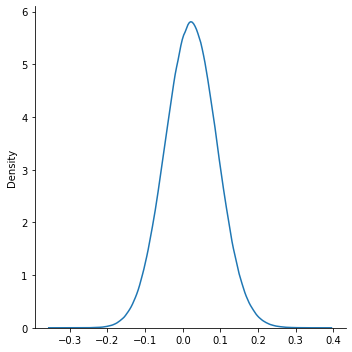

In [10]:
import seaborn as sns
sns.displot(x = np.concatenate(normal_features.values), kind="kde")

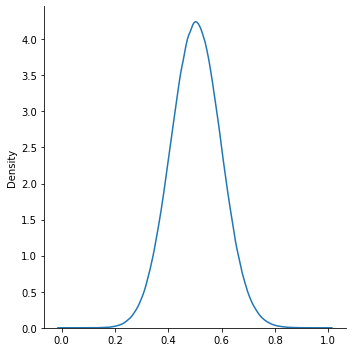

In [23]:
x = tr.fit_transform(np.array(normal_features.to_list()))
sns.displot(x = np.concatenate(x), kind="kde")

# GridSearchCV

## Building and training the different Models

In [4]:
# model settings
n_z = 100
n_channels = 1
n_feature_maps = 64

adversarial_weight = 1
contextual_weight = 1
encoder_weight = 1
lambda_weight = 0.5

# training settings
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
n_gpus = 0
workers = 2
batch_size = 16
max_epochs = 50
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# extra callbacks
callbacks = []

# run number
run = 1000

### Stacked Time Series

In [5]:
gan_stacked_time_series =\
build_model(
    model = Ganomaly2d,
    
    # model parameters
    input_size = 56, 
    n_z = n_z,
    n_channels = n_channels,
    n_fm_discriminator = n_feature_maps,  
    n_fm_generator = n_feature_maps,
    adversarial_weight = adversarial_weight,
    contextual_weight = contextual_weight, 
    encoder_weight = encoder_weight,
    lambda_weight = lambda_weight,
    
    # training parameters
    device = device,
    n_gpus = n_gpus,
    workers = workers,
    batch_size = batch_size,
    max_epochs = max_epochs, 
    lr = 0.0001,
    beta1 = 0.5,
    beta2 = 0.999, 
    
    # extra callbacks
    callbacks = callbacks
)

In [6]:
pipeline_stacked_time_series = \
Pipeline(steps=[
                ('reshaper', tfs.ArrayReshaper((1, 56, 56))),
                ('scaler', tfs.ArrayMinMaxScaler()),
                ('retyper', tfs.ArrayRetyper(np.float32)),
                ('model', gan_stacked_time_series)
               ])

In [7]:
search_space = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90]

search_parameters = \
[
    {
    'model__module__fraud_weight': search_space,
    },
    {
    'model__module__appearant_weight': search_space,
    },
    {
    'model__module__latent_weight': search_space,
    }

]

In [8]:
ganomaly_gs = GridSearchCV(pipeline_stacked_time_series, search_parameters, refit=False, cv=4)

In [9]:
ganomaly_gs.fit(normal_features_train)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000213417200D0>
Traceback (most recent call last):
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\site-packages\torch\utils\data\dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\jlsachse\Anaconda3\envs\AnomalyGan\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [13]:
import pandas as pd

for iteration in range(4):
    
    param_df = pd.DataFrame([[list(entry.keys())[0], list(entry.values())[0]] for entry in ganomaly_gs.cv_results_['params']]).rename({0: 'hyperparameter', 1: 'value'}, axis = 1)
    results_df = pd.DataFrame([abs(ganomaly_gs.cv_results_[f'split{iteration}_test_generator_loss']), abs(ganomaly_gs.cv_results_[f'split{iteration}_test_train_loss'])]).T.rename({0: 'generator_loss', 1: 'train_loss'}, axis = 1)

    results_df = pd.concat([param_df, results_df], axis = 1)
    results_df['hyperparameter'] = results_df['hyperparameter'].str.replace('model__module__', '')
    
    
    if iteration > 0:
        results_df = pd.concat([last_df, results_df])
    
    last_df = results_df

results_df

,hyperparameter,value,generator_loss,train_loss
0,fraud_weight,0,0.042200,0.042253
1,fraud_weight,1,0.032913,0.032965
2,fraud_weight,10,0.018350,0.018403
3,fraud_weight,20,0.015480,0.015526
4,fraud_weight,30,0.013275,0.013325
...,...,...,...,...
28,latent_weight,50,0.013664,0.013713
29,latent_weight,60,0.011440,0.011491
30,latent_weight,70,0.011639,0.011692
31,latent_weight,80,0.016513,0.016567


In [20]:
sns.set(rc={'figure.figsize':(12, 6)}, style = 'darkgrid')

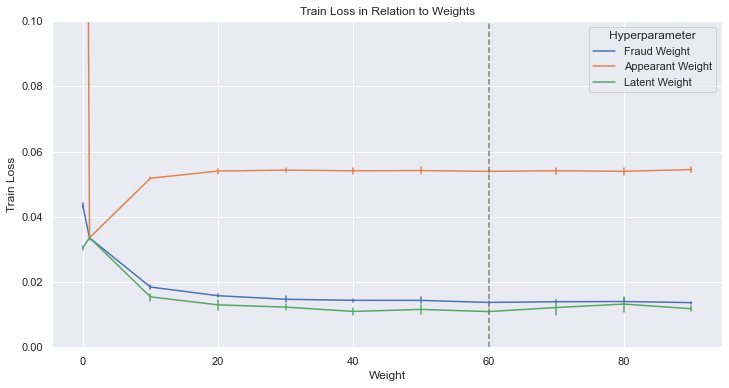

In [70]:
train_loss_figure, train_loss_ax = plt.subplots()
train_loss_ax = sns.lineplot(data = results_df, x = 'value', y = 'train_loss', hue = 'hyperparameter', err_style='bars', ax = train_loss_ax)
weight = results_df.groupby(['hyperparameter', 'value']).mean().idxmin()['train_loss'][1]

train_loss_ax.axvline(weight, ls='--', color = 'grey')
train_loss_ax.set_ylim(0, 0.1)
train_loss_ax.set_ylabel('Train Loss')
train_loss_ax.set_xlabel('Weight')
train_loss_ax.set_title('Train Loss in Relation to Weights')

legend = train_loss_ax.legend_
legend.set_title('Hyperparameter')
for text in legend.texts:
    text.set_text(text.get_text().title().replace('_', ' '))
    
train_loss_figure.savefig('data/results/hyperparameter-tuning_train-loss.png', dpi=330, bbox_inches='tight')

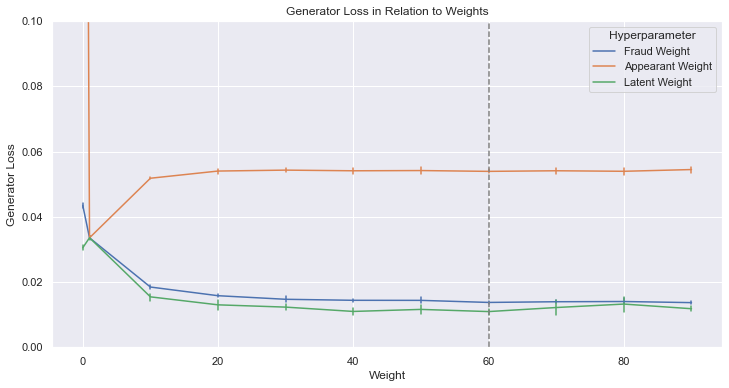

In [69]:
generator_loss_figure, generator_loss_ax = plt.subplots()
generator_loss_ax = sns.lineplot(data = results_df, x = 'value', y = 'generator_loss', hue = 'hyperparameter', err_style='bars', ax = generator_loss_ax)
weight = results_df.groupby(['hyperparameter', 'value']).mean().idxmin()['generator_loss'][1]

generator_loss_ax.axvline(weight, ls='--', color = 'grey')
generator_loss_ax.set_ylim(0, 0.1)
generator_loss_ax.set_ylabel('Generator Loss')
generator_loss_ax.set_xlabel('Weight')
generator_loss_ax.set_title('Generator Loss in Relation to Weights')

legend = generator_loss_ax.legend_
legend.set_title('Hyperparameter')
for text in legend.texts:
    text.set_text(text.get_text().title().replace('_', ' '))
    
generator_loss_figure.savefig('data/results/hyperparameter-tuning_generator-loss.png', dpi=330, bbox_inches='tight')